In [1]:
import  os
import  tensorflow as tf
import  numpy as np
from    tensorflow import keras
from    tensorflow.keras import Sequential, layers
from    PIL import Image
from    matplotlib import pyplot as plt
import  datetime

In [2]:
tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

对图像进行处理，转换为tensor形式

In [4]:
# 读入图片
img = tf.io.read_file('peppers.png')

# 解码为tensor格式
img = tf.image.decode_jpeg(img)
print('shape:', img.shape, 'dtype:', img.dtype)

# 将图片转换问灰度图片，即最后一维只有1
#img = tf.image.rgb_to_grayscale(img)
#print('shape:', img.shape, 'dtype:', img.dtype)

img = (tf.cast(img, dtype = tf.float32))/255

shape: (256, 256, 1) dtype: <dtype: 'uint8'>


构建变分自编码网络模型

编码器含有一个隐藏层，维度为64

解码器含有一个隐藏层，维度为64

隐变量z维度为16

In [5]:
h_dim = 64
z_dim = 16

In [6]:
class VAE(keras.Model):

    def __init__(self):
        super(VAE, self).__init__()

        # 编码器
        self.fc1 = layers.Dense(64)
        self.fc2 = layers.Dense(z_dim) 
        self.fc3 = layers.Dense(z_dim)

        # 解码器
        self.fc4 = layers.Dense(64)
        self.fc5 = layers.Dense(65536)


    def encoder(self, x):

        h = tf.nn.relu(self.fc1(x))
        # get mean
        mu = self.fc2(h)
        # get variance
        log_var = self.fc3(h)

        return mu, log_var

    def decoder(self, z):

        out = tf.nn.relu(self.fc4(z))
        out = self.fc5(out)

        return out

    def reparameterize(self, mu, log_var):

        eps = tf.random.normal(log_var.shape)

        std = tf.exp(log_var*0.5)

        z = mu + std * eps
        return z

    def call(self, inputs, training=None):

        # [b, 784] => [b, z_dim], [b, z_dim]
        mu, log_var = self.encoder(inputs)
        # reparameterization trick
        z = self.reparameterize(mu, log_var)

        x_hat = self.decoder(z)

        return x_hat, mu, log_var

In [7]:
lr = 1e-3 #学习率

In [8]:
model = VAE()
model.build(input_shape=(1, 65536))
optimizer = tf.optimizers.Adam(lr)

In [9]:
total_iterations=10000
y_loss=np.zeros(total_iterations) 

In [10]:
for iteration in range(total_iterations):
    x = tf.reshape(img, [1,65536])
    with tf.GradientTape() as tape:
            x_rec_logits, mu, log_var = model(x)
            rec_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_rec_logits)
            rec_loss = tf.reduce_sum(rec_loss) 
            kl_div = -0.5 * (log_var + 1 - mu**2 - tf.exp(log_var))
            kl_div = tf.reduce_sum(kl_div) 
            loss = rec_loss + 1. * kl_div
            y_loss[iteration]=float(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if iteration % 1000 == 0:
            print('kl div:', float(kl_div), 'rec loss:', float(rec_loss))

kl div: 7.206394672393799 rec loss: 45427.8515625
kl div: 3.071150064468384 rec loss: 40202.56640625
kl div: 9.497095108032227 rec loss: 39206.9453125
kl div: 11.351583480834961 rec loss: 39148.46875
kl div: 10.898106575012207 rec loss: 39138.91015625
kl div: 9.811281204223633 rec loss: 39138.125
kl div: 8.47508430480957 rec loss: 39144.1015625
kl div: 7.049210548400879 rec loss: 39138.5390625
kl div: 5.611464500427246 rec loss: 39139.0234375
kl div: 4.185920238494873 rec loss: 39141.296875


Text(0.5, 1.0, 'Peppers')

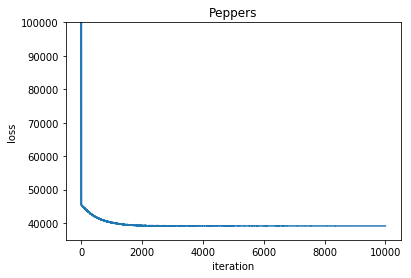

In [11]:
plt.plot(range(total_iterations), y_loss, label="First")
plt.ylim(35000, 100000)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Peppers') 

In [12]:
model.save_weights('model_peppers.h5')

In [13]:
model.load_weights('model_peppers.h5')

In [14]:
model.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  4194368   
_________________________________________________________________
dense_1 (Dense)              multiple                  1040      
_________________________________________________________________
dense_2 (Dense)              multiple                  1040      
_________________________________________________________________
dense_3 (Dense)              multiple                  1088      
_________________________________________________________________
dense_4 (Dense)              multiple                  4259840   
Total params: 8,457,376
Trainable params: 8,457,376
Non-trainable params: 0
_________________________________________________________________


通过训练后的变分自编码网络生成模型来生成图像

In [15]:
z = tf.random.normal((1, z_dim))  #构造长度为z_dim的随机向量，进行decode，可sample出原图
logits = model.decoder(z)
x_hat = tf.sigmoid(logits)
x_hat = tf.reshape(x_hat, [-1, 256, 256]).numpy() *255.
x_hat = x_hat.astype(np.uint8)

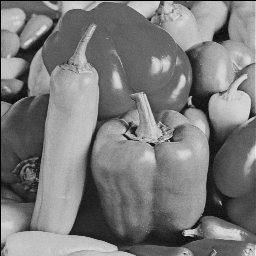

In [16]:
data = np.reshape(x_hat,(256,256))
new_im = Image.fromarray(data)
new_im

图像重构效果

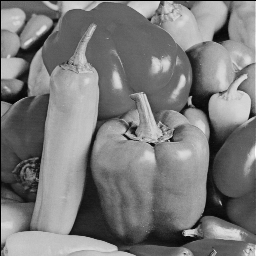

In [17]:
x = img
x = tf.reshape(x, [-1, 65536])
x_hat_logits, _, _ = model(x)
x_hat = tf.sigmoid(x_hat_logits)
x_hat = tf.reshape(x_hat, [-1, 256, 256]).numpy() *255.
x_hat = x_hat.astype(np.uint8)
data = np.reshape(x_hat,(256,256))
new_im = Image.fromarray(data)
new_im